In [32]:
#Remarks
#check coefficients against equations
#be careful of copying and reassign values in numpy array
#export frequencies
#add pot_inf,ex_inf,ey_inf,ez_inf variables and assign s appropriately
#test case case=0 to test set_subdomains
#consider remove set_subdomain and change nnode to nnode_active
#specify as elements[in_active_zones,:] instead of elements[in_active_zones] and etc. except that dimension may vary by cases (e.g. cx/cy/cz)
#consider renaming in 'for irow in np.asmatrix(rows).T:' (done)
#let cx/cy/cz etc values on curved surface not 3d space in set_materials3d for case=3 (done)
#set_first_kind_bc3d may need to be updated for K.shape as (nnode*4,nnode*4) (changed ways to do this)
#add function zero_inactive_nodes (done)
#modify set_first_kind_bc to accomendate more rows in K
#take care of sigma_solid and gs signs by including direction of normal surface vector
#check Young–Laplace equation solution and use it to benchmark curved surface
#continue from Test 4 use numerical solution as input for unod1 (which is previous implementaion in set_materials2d) (problem is that mesh is too coarse on sphere)
#change u/unod to size of (*,4)

#Naming conventions
#unod3d is only used since unod2d does not exist due to indexing system; always a 1d vector
#u2d,u3d represent short version of uele_2d and uele_3d; each have four columns (first as field; rest as gradient vector)

#Test Case
# define materials using functions in each test case

#Unsolved
#distance scaling factor does not work for coupled problem

In [11]:
#https://github.com/nipy/mindboggle/blob/master/mindboggle/shapes/laplace_beltrami.py
import numpy as np
from shapes.laplace_beltrami import computeAB
points = [[0,0,0], [1,0,0], [0,0,1], [0,1,1],
          [1,0,1], [0,1,0], [1,1,1], [1,1,0]]
points = np.array(points)
faces = [[0,2,4], [0,1,4], [2,3,4], [3,4,5], [3,5,6], [0,1,7]]
faces = np.array(faces)
A, B = computeAB(points, faces)
# print(np.array_str(A.toarray(), precision=5, suppress_small=True))
# print(np.array_str(A.toarray(), precision=5, suppress_small=True))

In [18]:
#https://gist.github.com/venuktan/8910385
import numpy as N
import scipy as S
def coo_submatrix_pull(matr, rows, cols):
    """
    Pulls out an arbitrary i.e. non-contiguous submatrix out of
    a sparse.coo_matrix. 
    """
    if type(matr) != S.sparse.coo_matrix:
        raise TypeError('Matrix must be sparse COOrdinate format')
    
    gr = -1 * N.ones(matr.shape[0])
    gc = -1 * N.ones(matr.shape[1])
    
    lr = len(rows)
    lc = len(cols)
    
    ar = N.arange(0, lr)
    ac = N.arange(0, lc)
    gr[rows[ar]] = ar
    gc[cols[ac]] = ac
    mrow = matr.row
    mcol = matr.col
    newelem = (gr[mrow] > -1) & (gc[mcol] > -1)
    newrows = mrow[newelem]
    newcols = mcol[newelem]
    return S.sparse.coo_matrix((matr.data[newelem], N.array([gr[newrows],
        gc[newcols]])),(lr, lc))

# Main Functions

In [2]:
%reset -f
import copy,h5py,os,time
import numpy as np
import numpy.matlib
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import block_diag

#set physicsical constants
echarge=1.602e-19 #elementary charge [C]
perm0=8.85e-12 #vacuum permittivity [F/m]
kA=6.022e23 #Avogadro constant [1/mol]
kB=1.381e-23 #Boltzmann's constant [J/K]

def system_check():
    print('Run system check')
    #print('Default numpy.int is %d bits'%np.finfo(int).bits)
    print('Default numpy.float is %d bits'%np.finfo(float).bits)
    
    return

def import_mesh(infile):
    print('Reading group mesh from %s'%infile)
    with h5py.File(infile,'r') as file:
        nodes=np.array(file['mesh/nodes']).astype(float)
        elements=np.array(file['mesh/elements']).astype(int)
        faces=np.array(file['mesh/faces']).astype(int)
        
        in_active_zones=np.array(file['mesh/in_active_zones']).astype(bool)
        with_first_kind_bc=np.array(file['mesh/with_first_kind_bc']).astype(bool)
        with_third_kind_bc=np.array(file['mesh/with_third_kind_bc']).astype(bool)
        
        in_electrolyte=np.array(file['mesh/in_electrolyte']).astype(bool)
        in_solid=np.array(file['mesh/in_solid']).astype(bool)
        in_stern=np.array(file['mesh/in_stern']).astype(bool)
                
    nind_e=np.unique(elements[in_active_zones,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_e))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',np.count_nonzero(with_first_kind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')
    
    mesh={'elements':elements,'nodes':nodes,'faces':faces,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern}
    
    return mesh

def import_physics(infile):
    print('Reading group physics from %s'%infile)
    with h5py.File(infile,'r') as file:
        rel_perm_electrolyte=np.array(file['physics/rel_perm_electrolyte'])
        rel_perm_solid=np.array(file['physics/rel_perm_solid'])
        diffusion_electrolyte=np.array(file['physics/diffusion_electrolyte'])
        diffusion_stern=np.array(file['physics/diffusion_stern'])
        mobility_electrolyte=np.array(file['physics/mobility_electrolyte'])
        mobility_stern=np.array(file['physics/mobility_stern'])
        temp_K=np.array(file['physics/temperature'])
        cinf=np.array(file['physics/ion_conc_inf'])
        zval=np.array(file['physics/ion_val'])
        sigma_solid=np.array(file['physics/sigma_solid'])
        ratio_p=np.array(file['physics/ratio_p'])
        sigma_stern=-ratio_p*sigma_solid
        sigma_electrolyte=-(1-ratio_p)*sigma_solid
        
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS:',sigma_solid)
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',sigma_stern)
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',sigma_electrolyte)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval,
             'sigma_solid':sigma_solid,'sigma_stern':sigma_stern,
             'sigma_electrolyte':sigma_electrolyte}
    
    return physics

def scale_mesh(mesh_in,dist_factor):
    print('Scaling distance in mesh')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    mesh=copy.deepcopy(mesh_in)    
    mesh['nodes']=mesh['nodes']*dist_factor
        
    return mesh

def scale_materials(materials_in,dist_factor):
    print('Scaling distance in materials')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    materials=copy.deepcopy(materials_in)
    
    materials['cx']=materials['cx']/1
    materials['cy']=materials['cy']/1
    materials['cz']=materials['cz']/1

    materials['alpha_x']=materials['alpha_x']/dist_factor
    materials['alpha_y']=materials['alpha_y']/dist_factor
    materials['alpha_z']=materials['alpha_z']/dist_factor

    materials['beta_x']=materials['beta_x']/dist_factor
    materials['beta_y']=materials['beta_y']/dist_factor
    materials['beta_z']=materials['beta_z']/dist_factor

    materials['gamma_x']=materials['gamma_x']/dist_factor
    materials['gamma_y']=materials['gamma_y']/dist_factor
    materials['gamma_z']=materials['gamma_z']/dist_factor

    materials['a']=materials['a']/dist_factor**2
    materials['f']=materials['f']/dist_factor**2    
    materials['gs']=materials['gs']/dist_factor
    materials['qs']=materials['qs']/dist_factor
    materials['snod']=materials['snod']/1
            
    return materials

def grad2d(nodes,faces,unod,dist_factor=1,local=1):
    print('Computing fields and field gradients on faces')
    start=time.time()
    
    nface=len(faces)
    u2d=np.zeros((nface,7),dtype=complex)
    Je=np.ones((3,3))
    for i in range(nface): #consider parallelization
        nind=faces[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T

        Je[1:,:]=nodes_new[:,:-1].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes_new[:,0])/3
        yr=sum(nodes_new[:,1])/3
        u2d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])
        
        dudx=sum(unod[nind]*invJe[:,1])
        dudy=sum(unod[nind]*invJe[:,2])
        u2d[i,1:4]=[dudx,dudy,0]
        u2d[i,4:7]=np.linalg.inv(R).dot([dudx,dudy,0])
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    
    if local:
        u2d=u2d[:,[0,1,2,3]]
    else:
        u2d=u2d[:,[0,4,5,6]]
    
    return u2d*dist_factor

def grad3d(nodes,elements,unod,dist_factor=1):
    print('Computing fields and field gradients in elements')
    start=time.time()
    
    nelem=len(elements)
    u3d=np.zeros((nelem,4),dtype=complex)
    Je=np.ones((4,4))
    for i in range(nelem): #consider parallelization
        nind=elements[i,:]        
        Je[1:,:]=nodes[nind,:].T
        invJe=np.linalg.inv(Je)

        xr=.25*sum(nodes[nind,0])
        yr=.25*sum(nodes[nind,1])
        zr=.25*sum(nodes[nind,2])
        u3d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr+invJe[:,3]*zr)*unod[nind])
        u3d[i,1]=sum(unod[nind]*invJe[:,1])
        u3d[i,2]=sum(unod[nind]*invJe[:,2])
        u3d[i,3]=sum(unod[nind]*invJe[:,3])
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return u3d*dist_factor

def rotate_triangle(nodes):
    A=np.zeros((3,3))
    R=np.zeros((3,3))
    
    xnod=nodes[:,0]
    ynod=nodes[:,1]
    znod=nodes[:,2]
    
    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2
    
    n=n/np.linalg.norm(n)
    z=np.array([0,0,1])
    k=np.cross(n,z)
    norm_k=np.linalg.norm(k)
    if norm_k>1e-8:
        k=k/norm_k

        cosb=np.dot(n,z)
        sinb=np.sqrt(1-cosb**2)

        A[0,:]=[0,-k[2],k[1]]
        A[1,:]=[k[2],0,-k[0]]
        A[2,:]=[-k[1],k[0],0]
        R=np.eye(3)+A.dot(sinb)+A.dot(A.dot(1-cosb))
    else:
        R=np.eye(3)
    
    return R

def output_unod(nodes,unod,srvfile):
    output=np.genfromtxt(srvfile,skip_header=1)
    rec=output[:,1:4]
    for i in range(len(rec)):
        dist2=(rec[i,0]-nodes[:,0])**2+(rec[i,1]-nodes[:,1])**2+(rec[i,2]-nodes[:,2])**2
        ind=np.argmin(dist2)
        output[i,6]=np.real(unod[ind])
        output[i,7]=np.imag(unod[ind])
    
    outfile=srvfile+'.out'
    fmt='%d\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e'
    print('Saving results to %s'%outfile)
    np.savetxt(outfile,output,header=str(len(output)),comments='',fmt=fmt)
    print('')
    return output

def assemble_Ke2d3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (2/2)')
    start=time.time()
    in_stern=mesh['in_stern']
    
    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)
    
    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    
    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d3d(xnod,ynod,gamma_x=gamma_x[i],
                           gamma_y=gamma_y[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ks3d2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (1/2)')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc'] #identical to in_stern
    
    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)
    
    gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d2d(xnod,ynod,znod,gs=gs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ke2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_stern=mesh['in_stern']
    
    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)
    
    cx=np.reshape(materials['cx'][in_stern],(nface_stern,nrep,nrep))
    cy=np.reshape(materials['cy'][in_stern],(nface_stern,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_stern],(nface_stern,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_stern],(nface_stern,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_stern],(nface_stern,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_stern],(nface_stern,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))
    a=np.reshape(materials['a'][in_stern],(nface_stern,nrep,nrep))
    f=np.reshape(materials['f'][in_stern],(nface_stern,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    
    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d(xnod,ynod,cx=cx[i],cy=cy[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],
                         a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ke3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']
    
    nodes=mesh['nodes']
    elements_in=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_in=len(elements_in)
    
    cx=np.reshape(materials['cx'][in_active_zones],(nelem_in,nrep,nrep))
    cy=np.reshape(materials['cy'][in_active_zones],(nelem_in,nrep,nrep))
    cz=np.reshape(materials['cz'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_z=np.reshape(materials['alpha_z'][in_active_zones],(nelem_in,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_in,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_in,nrep,nrep))
    beta_z=np.reshape(materials['beta_z'][in_active_zones],(nelem_in,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_in,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_in,nrep))
    gamma_z=np.reshape(materials['gamma_z'][in_active_zones],(nelem_in,nrep))
    a=np.reshape(materials['a'][in_active_zones],(nelem_in,nrep,nrep))
    f=np.reshape(materials['f'][in_active_zones],(nelem_in,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_in*16*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(4*nrep),4*nrep,1).T
    COL=np.matlib.repmat(np.arange(4*nrep),4*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    
    for i in range(nelem_in):
        nind=elements_in[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ke,be=build_Ke3d(xnod,ynod,znod,cx=cx[i],cy=cy[i],cz=cz[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],alpha_z=alpha_z[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],beta_z=beta_z[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],gamma_z=gamma_z[i],
                         a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+16*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+16*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+16*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+16*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ks3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc']
    
    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)
    
    gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
    qs=np.reshape(materials['qs'][with_third_kind_bc],(nface_bc,nrep,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d(xnod,ynod,znod,gs=gs[i],qs=qs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_first_kind_bc3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    with_first_kind_bc=mesh['with_first_kind_bc']
    
    nodes=mesh['nodes']
    nodes_bc=mesh['nodes'][with_first_kind_bc]
    nnode=len(nodes)
    nnode_bc=len(nodes_bc)
    snod=np.reshape(materials['snod'][with_first_kind_bc],(nnode_bc,nrep))
    
    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_bc=np.where(with_first_kind_bc)[0]
    nind_in=np.where(~with_first_kind_bc)[0]
    
    for i in nind_in:
        rows=REP[i,:].flatten(order='C')+offset[0]
        cols=REP[nind_bc,:].flatten(order='C')+offset[1]
        for j in np.asmatrix(rows).T: #to be compatible if rows is a scalar
            b[j]=b[j]-K[j,cols].dot(snod.flatten(order='C'))
    
    rows=REP[nind_bc,:].flatten(order='C')+offset[0]
    cols=REP[nind_bc,:].flatten(order='C')+offset[1]    
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1
    K=zero_rows(K,rows)
    K=zero_cols(K,cols)
    b[rows]=snod.flatten(order='C')
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes2d(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    faces=mesh['faces']
    in_stern=mesh['in_stern']
    nnode=len(mesh['nodes'])

    nind_stern=np.unique(faces[in_stern].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_stern]=0
    
    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_out=np.where(mask_inactive)[0]
    
    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]    
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes3d(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    elements=mesh['elements']
    in_active_zones=mesh['in_active_zones']
    nnode=len(mesh['nodes'])
    
    nind_in=np.unique(elements[in_active_zones].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_in]=0
    
    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    nind_out=np.where(mask_inactive)[0]
    
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]    
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def build_Ke2d3d(xnod,ynod,gamma_x,gamma_y,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2
    
    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
            #         +a[kk,ll]*(1+delta_ij)/12+
            #         (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3+
            #         (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3)*area
            Ke[i,j]=(gamma_x[kk]*invJe[ii,1]*invJe[jj,1]+
                     gamma_y[kk]*invJe[ii,2]*invJe[jj,2])*area*delta_kl
        #be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3)*area
    
    return -Ke,be

def build_Ks3d2d(xnod,ynod,znod,gs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)
    
    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2
    
    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ks[i,j]=qs[kk,ll]*area*(1+delta_ij)/12
            #replace qs[kk,ll] above with gs[kk]*delta_kl
            #gs[kk]*delta_kl is equivalent to qs[kk,ll]
            #in terms of indexing (both vary with kk and ll)
            Ks[i,j]=gs[kk]*delta_kl*area*(1+delta_ij)/12
        #bs[i]=gs[kk]*area/3
        #bs is a placeholder; unused
    
    #don't forget return -Ks instead of Ks
    return -Ks,bs

def build_Ke2d(xnod,ynod,cx,cy,alpha_x,alpha_y,beta_x,
               beta_y,gamma_x,gamma_y,a,f,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2
    
    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     +a[kk,ll]*(1+delta)/12+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3)*area
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3)*area
    
    return Ke,be

def build_Ke3d(xnod,ynod,znod,cx,cy,cz,alpha_x,alpha_y,alpha_z,beta_x,
               beta_y,beta_z,gamma_x,gamma_y,gamma_z,a,f,nrep=1):
    Ke=np.zeros((4*nrep,4*nrep),dtype=complex)
    be=np.zeros(4*nrep,dtype=complex)
    Je=np.ones((4,4))
    Je[1,:]=xnod
    Je[2,:]=ynod
    Je[3,:]=znod
    invJe=np.linalg.inv(Je)
    vol=np.linalg.det(Je)/6
    
    for i in range(4*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3,4
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(4*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3,4
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     cz[kk,ll]*invJe[ii,3]*invJe[jj,3]+a[kk,ll]*(1+delta)/20+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2]+alpha_z[kk,ll]*invJe[ii,3])/4+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2]+beta_z[kk,ll]*invJe[jj,3])/4)*vol
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+gamma_z[kk]*invJe[ii,3]+f[kk]/4)*vol
    
    return Ke,be

def build_Ks3d(xnod,ynod,znod,gs,qs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)
    
    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2
    
    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ks[i,j]=qs[kk,ll]*area*(1+delta)/12
        bs[i]=gs[kk]*area/3
    
    return Ks,bs

def zero_rows(M,rows):
    diag=sparse.eye(M.shape[0]).tolil()
    for r in rows:
        diag[r,r]=0
    #diag[rows,rows]=0
    return diag.dot(M)

def zero_cols(M,cols):
    diag=sparse.eye(M.shape[0]).tolil()
    for c in cols:
        diag[c,c]=0
    #diag[cols,cols]=0
    return M.dot(diag)
    
def call_solver(K,b):
    print('Calling sparse linear system solver')
    start=time.time()
    K.eliminate_zeros()
    solution=spsolve(K,b)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    
    return solution

def reshape_solution(solution,nrep=1):
    nnode=int(len(solution)/nrep/2)
    
    unod_list=[]    
    unod=np.reshape(solution[:nnode*nrep],(nnode,nrep))
    for i in range(nrep):
        unod_list.append(unod[:,i])
    
    unod=np.reshape(solution[nnode*nrep:],(nnode,nrep))
    for i in range(nrep):
        unod_list.append(unod[:,i])
    
    return unod_list

def ansol_sphere(r,a,rel_perm,temp_K,cinf,zval,zeta,gradflag=0):
    print('Computing 1D linar PB solution in spherical coordinates')
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('SOLID PARTICLE RADIUS IS:',a)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    if gradflag:
        print('SURFACE CHARGE DENSITY AT SPHERE IS:',zeta)
    else:
        print('POTENTIAL AT SPHERE IS:',zeta)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    print('')
    
    if gradflag:
        zeta=zeta/(1/debye_len+1/a)/perm0/rel_perm
    
    dist=np.sqrt(r[:,0]**2+r[:,1]**2+r[:,2]**2)
    u=np.zeros((len(dist),4))
    mask=dist>=a
    u[mask,0]=zeta*a*np.exp((a-dist[mask])/debye_len)/dist[mask]
    u[~mask,0]=zeta
    u[mask,1]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,0]/dist[mask]
    u[mask,2]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,1]/dist[mask]
    u[mask,3]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,2]/dist[mask]
    return u

def cartesian2spherical(x,y,z):
    rho=np.sqrt(x**2+y**2+z**2) #radial distance
    theta=np.arccos(z/rho) #polar angle
    #phi=np.arctan2(y/x)
    phi=np.zeros_like(rho)+np.pi/2 #azimuthal angle
    mask=x>0
    phi[mask]=np.arctan(y[mask]/x[mask])
    mask=x<0
    phi[mask]=np.arctan(y[mask]/x[mask])+np.pi
    
    return rho,theta,phi

def compute_midpoints2d(nodes,faces,dist_factor=1):
    #compute middle point of face element (efficiency to be improved)
    nface=len(faces[:,0])
    midpoints=np.zeros((nface,3))
    for i in range(0,nface):
        for j in range(0,3):
            midpoints[i,j]=sum(nodes[faces[i,:],j])/3
    
    return midpoints*dist_factor

def compute_midpoints3d(nodes,elements,dist_factor=1):
    #compute middle point of volume element (efficiency to be improved)
    nelem=len(elements[:,0])
    midpoints=np.zeros((nelem,3))
    for i in range(0,nelem):
        for j in range(0,3):
            midpoints[i,j]=.25*sum(nodes[elements[i,:],j])
    
    return midpoints*dist_factor

def compute_tangent(nodes,faces,u2d_in):
    u2d=np.array(u2d_in)
    nface=len(faces)
    for i in range(len(faces)):
    #for i in range(1):
        nind=faces[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        
        a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
        b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
        n=np.cross(a,b)
        n=n/np.linalg.norm(n)
        
        normal=np.dot(u2d_in[i,1:],n)*n
        u2d[i,1:]=u2d_in[i,1:]-normal
    
    return u2d

if __name__=='__main__':
    print('Done')


Done


# Run System Check

In [11]:
system_check()

Run system check
Default numpy.float is 64 bits


# Test Surface Gradient

Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Computing fields and field gradients on faces
Time elapsed  2.5527122020721436 sec

Computing fields and field gradients on faces
Time elapsed  2.5506162643432617 sec

Computing fields and field gradients in elements
Time elapsed  4.309488773345947 sec



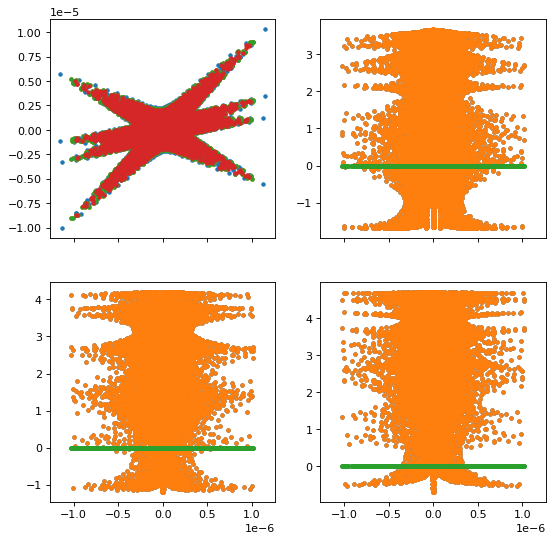

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

meshfile='sphere_s61.hdf5'
mesh=import_mesh(meshfile)

nodes=mesh['nodes']
elements=mesh['elements']
faces=mesh['faces']

unod=nodes[:,0]*2+nodes[:,1]*3+nodes[:,2]*4

u2d_local=grad2d(nodes,faces,unod,local=1)
u2d_global=grad2d(nodes,faces,unod,local=0)
u2d_tangent=compute_tangent(nodes,faces,np.array([[0,2.0,3.0,4.0]]*len(faces)))
u3d=grad3d(nodes,elements,unod)

midpoints2d=compute_midpoints2d(nodes,faces)
midpoints3d=compute_midpoints3d(nodes,elements)

fig,ax=plt.subplots(2,2,sharex=True,sharey=False,figsize=(8,8),dpi=80)
axs=ax.flatten()
axs[0].plot(nodes[:,0],unod,'.')
axs[0].plot(midpoints2d[:,0],np.real(u2d_local[:,0]),'.')
axs[0].plot(midpoints2d[:,0],np.real(u2d_global[:,0]),'.')
axs[0].plot(midpoints3d[:,0],np.real(u3d[:,0]),'.')

axs[1].plot(midpoints2d[:,0],np.real(u2d_global[:,1]),'.')
axs[1].plot(midpoints2d[:,0],np.real(u2d_tangent[:,1]),'.')
axs[1].plot(midpoints2d[:,0],np.real(u2d_global[:,1]-u2d_tangent[:,1]),'.')

axs[2].plot(midpoints2d[:,0],np.real(u2d_global[:,2]),'.')
axs[2].plot(midpoints2d[:,0],np.real(u2d_tangent[:,2]),'.')
axs[2].plot(midpoints2d[:,0],np.real(u2d_global[:,2]-u2d_tangent[:,2]),'.')

axs[3].plot(midpoints2d[:,0],np.real(u2d_global[:,3]),'.')
axs[3].plot(midpoints2d[:,0],np.real(u2d_tangent[:,3]),'.')
axs[3].plot(midpoints2d[:,0],np.real(u2d_global[:,3]-u2d_tangent[:,3]),'.')
plt.show()

# Test Case 1 (Subdomain/K11/K22)

In [25]:
def set_materials2d(mesh,physics,u2d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
        
    c=np.zeros(nface,dtype=complex)
    alpha_x=np.zeros(nface,dtype=complex)
    alpha_y=np.zeros(nface,dtype=complex)
    alpha_z=np.zeros(nface,dtype=complex)

    beta_x=np.zeros(nface,dtype=complex)
    beta_y=np.zeros(nface,dtype=complex)
    beta_z=np.zeros(nface,dtype=complex)

    gamma_x=np.zeros(nface,dtype=complex)
    gamma_y=np.zeros(nface,dtype=complex)
    gamma_z=np.zeros(nface,dtype=complex)

    a=np.zeros(nface,dtype=complex)
    f=np.zeros(nface,dtype=complex)
    gs=0 #placeholder; not implemented yet
    qs=0 #placeholder; not implemented yet
    snod=0 #placeholder; not implemented yet
    
    c[in_stern]=physics['diffusion_stern']
    gamma_x[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_y[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_z[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    a[in_stern]=1j*freq
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    return materials
    
def set_materials3d(mesh,physics,u3d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
        
    c=np.zeros(nelem,dtype=complex)
    alpha_x=np.zeros(nelem,dtype=complex)
    alpha_y=np.zeros(nelem,dtype=complex)
    alpha_z=np.zeros(nelem,dtype=complex)

    beta_x=np.zeros(nelem,dtype=complex)
    beta_y=np.zeros(nelem,dtype=complex)
    beta_z=np.zeros(nelem,dtype=complex)

    gamma_x=np.zeros(nelem,dtype=complex)
    gamma_y=np.zeros(nelem,dtype=complex)
    gamma_z=np.zeros(nelem,dtype=complex)

    a=np.zeros(nelem,dtype=complex)
    f=np.zeros(nelem,dtype=complex)
    gs=np.zeros(nface,dtype=complex)
    qs=np.zeros(nface,dtype=complex)
    snod=np.zeros(nnode,dtype=complex)
    
    c[in_electrolyte]=perm0*physics['rel_perm_electrolyte']
    c[in_solid]=perm0*physics['rel_perm_solid']
    gs[in_stern]=-physics['sigma_electrolyte']

    ze=zval*echarge #ion valence times elementary charge
    u3d_scale=ze*u3d[:,0]/kB/temp_K #scaled potential in elements
    a[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u3d_scale)
    f[:]=-2*ze*kA*cinf*(np.sinh(u3d_scale)-np.cosh(u3d_scale)*u3d_scale)
    a[in_solid]=0
    f[in_solid]=0
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    return materials

def build_system(mesh,materials2d,materials3d,case=1):
    nnode=len(mesh['nodes'])
    K=csr_matrix((nnode*2,nnode*2))
    b=np.zeros(nnode*2,dtype=complex)
    K,b=assemble_Ke3d(mesh,materials3d,K,b,offset=(0,0),nrep=1)
    K,b=assemble_Ks3d(mesh,materials3d,K,b,offset=(0,0),nrep=1)
    K,b=assemble_Ke2d(mesh,materials2d,K,b,offset=(nnode,nnode),nrep=1)
    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode,nnode),nrep=1)
    
    return K,b

if __name__=='__main__':
    #user input
    meshfile='sphere_s61_electrolyte.hdf5'
    physfile='sphere_s61_electrolyte.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    #dist_factor=1
    case=1
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    u2d=np.zeros((len(mesh['faces']),4))
    u3d=np.zeros((len(mesh['elements']),4))
    materials2d=set_materials2d(mesh,physics,u2d=u2d,freq=0.1,case=case)
    materials3d=set_materials3d(mesh,physics,u3d=u3d,freq=0.1,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)

    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    solution=call_solver(K/perm0,b/perm0)
    unod_list=reshape_solution(solution,nrep=1)
    output=output_unod(nodes,unod_list[0],srvfile)
    
    np.save('sphere_s61',solution)
    print('Done')


Reading group mesh from sphere_s61_electrolyte.hdf5
THE NUMBER OF ACTIVE NODES IS: 22705
THE NUMBER OF ACTIVE ELEMENTS IS: 123661
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61_electrolyte.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS: 0.02
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -0.01
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: -0.01

TEST CASE IS: 1
Setting material properties in Stern layer

TEST CASE IS: 1
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+09

Scaling distance 

# Test 5 (K12/K21)

In [3]:
def set_materials2d(mesh,physics,u2d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
        
    c=np.zeros((nface,3,3),dtype=complex)
    alpha_x=np.zeros((nface,3,3),dtype=complex)
    alpha_y=np.zeros((nface,3,3),dtype=complex)
    alpha_z=np.zeros((nface,3,3),dtype=complex)

    beta_x=np.zeros((nface,3,3),dtype=complex)
    beta_y=np.zeros((nface,3,3),dtype=complex)
    beta_z=np.zeros((nface,3,3),dtype=complex)

    gamma_x=np.zeros((nface,3),dtype=complex)
    gamma_y=np.zeros((nface,3),dtype=complex)
    gamma_z=np.zeros((nface,3),dtype=complex)

    a=np.zeros((nface,3,3),dtype=complex)
    f=np.zeros((nface,3),dtype=complex)
    gs=0j #placeholder; not implemented yet
    qs=0j #placeholder; not implemented yet
    snod=0j #placeholder; not implemented yet
        
    c[in_stern,2,2]=physics['diffusion_stern']
    gamma_x[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern'] #coupled coefficient
    gamma_y[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern'] #coupled coefficient
    gamma_z[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern'] #coupled coefficient
    a[in_stern,0,0]=1j*freq
    a[in_stern,1,1]=1j*freq
    a[in_stern,2,2]=1j*freq
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    return materials

def set_materials3d(mesh,physics,u3d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    
    c=np.zeros((nelem,3,3),dtype=complex)
    alpha_x=np.zeros((nelem,3,3),dtype=complex)
    alpha_y=np.zeros((nelem,3,3),dtype=complex)
    alpha_z=np.zeros((nelem,3,3),dtype=complex)

    beta_x=np.zeros((nelem,3,3),dtype=complex)
    beta_y=np.zeros((nelem,3,3),dtype=complex)
    beta_z=np.zeros((nelem,3,3),dtype=complex)

    gamma_x=np.zeros((nelem,3),dtype=complex)
    gamma_y=np.zeros((nelem,3),dtype=complex)
    gamma_z=np.zeros((nelem,3),dtype=complex)

    a=np.zeros((nelem,3,3),dtype=complex)
    f=np.zeros((nelem,3),dtype=complex)
    gs=np.zeros((nface,3),dtype=complex)
    qs=np.zeros((nface,3,3),dtype=complex)
    snod=np.zeros((nnode,3),dtype=complex)
            
    c[in_electrolyte,0,0]=physics['diffusion_electrolyte']
    c[in_electrolyte,1,1]=physics['diffusion_electrolyte']
    c[in_electrolyte,2,2]=perm0*physics['rel_perm_electrolyte']

    c[in_electrolyte,0,2]=-physics['mobility_electrolyte']*cinf*np.exp(u3d[in_electrolyte,0]*echarge/kB/temp_K)
    c[in_electrolyte,1,2]=physics['mobility_electrolyte']*cinf*np.exp(-u3d[in_electrolyte,0]*echarge/kB/temp_K)

    c[in_solid,0,0]=0
    c[in_solid,1,1]=0
    c[in_solid,2,2]=perm0*physics['rel_perm_solid']

    alpha_x[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,1] #to be verified for vectors inside matrix
    alpha_y[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,2] #to be verified for vectors inside matrix
    alpha_z[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,3] #to be verified for vectors inside matrix

    alpha_x[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,1] #to be verified for vectors inside matrix
    alpha_y[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,2] #to be verified for vectors inside matrix
    alpha_z[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,3] #to be verified for vectors inside matrix

    a[:,0,0]=1j*freq
    a[:,1,1]=1j*freq

    a[in_electrolyte,2,0]=kA*echarge
    a[in_electrolyte,2,1]=-kA*echarge

    gs[in_stern,0]=0 #coupled coefficient; need to verify sign
    gs[in_stern,1]=0 #coupled coefficient; need to verify sign
    gs[in_stern,2]=1 #coupled coefficient; need to verify sign

    nodes=mesh['nodes']
    with_first_kind_bc=mesh['with_first_kind_bc']
    snod[with_first_kind_bc,2]=nodes[with_first_kind_bc,0]*1e6 #need to be updated
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}    
    return materials

def build_system(mesh,materials2d,materials3d,case=1):
    nnode=len(mesh['nodes'])
    mats3d_zero_gs=copy.deepcopy(materials3d)
    mats3d_zero_gs['gs'][:]=0

    mats2d_zero_gamma=copy.deepcopy(materials2d)
    mats2d_zero_gamma['gamma_x'][:]=0
    mats2d_zero_gamma['gamma_y'][:]=0
    mats2d_zero_gamma['gamma_z'][:]=0

    K=csr_matrix((nnode*6,nnode*6),dtype=complex)
    b=np.zeros(nnode*6,dtype=complex)
    K,b=assemble_Ke3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=3) #K11 element
    K,b=assemble_Ks3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=3) #K11 face
    K,b=assemble_Ke2d(mesh,mats2d_zero_gamma,K,b,offset=(nnode*3,nnode*3),nrep=3) #K22 element

    K,b=assemble_Ks3d2d(mesh,materials3d,K,b,offset=(0,nnode*3),nrep=3) #coupled term of K12
    K,b=assemble_Ke2d3d(mesh,materials2d,K,b,offset=(nnode*3,0),nrep=3) #coupled term of K12

    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=3) #K11 1st kind b.c.
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*3,nnode*3),nrep=3)
    
    return K,b

if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    #dist_factor=1e9
    dist_factor=1
    case=5
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    midpoints3d=compute_midpoints3d(mesh['nodes'],mesh['elements'])
    ansol=ansol_sphere(midpoints3d,a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)
    materials2d=set_materials2d(mesh,physics,u2d=0,freq=10,case=case)
    materials3d=set_materials3d(mesh,physics,u3d=ansol,freq=10,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #solution=call_solver(K/perm0,b/perm0)
    solution=call_solver(K,b)
    unod_list=reshape_solution(solution,nrep=3)
    output=output_unod(nodes,unod_list[0],srvfile)
    
    np.save('sphere_s61',solution)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS: 0.02
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -0.01
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: -0.01

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT

In [9]:
K1=copy.deepcopy(K)
b1=copy.deepcopy(b)
solution1=copy.deepcopy(solution)

<class 'scipy.sparse.csr.csr_matrix'> <class 'numpy.ndarray'>


K66 nind: [ 72473  72476  72479 ... 144935 144938 144941]
K65 nind: [ 72472  72475  72478 ... 144934 144937 144940]
K64 nind: [ 72471  72474  72477 ... 144933 144936 144939]
K63 nind: [    2     5     8 ... 72464 72467 72470]
K62 nind: [    1     4     7 ... 72463 72466 72469]
K61 nind: [    0     3     6 ... 72462 72465 72468]

K65 max(real) max(imag): 0.0 0.0
K64 max(real) max(imag): 0.0 0.0
K62 max(real) max(imag): 0.0 0.0
K61 max(real) max(imag): 0.0 0.0

Calling sparse linear system solver
Time elapsed  0.01407170295715332 sec



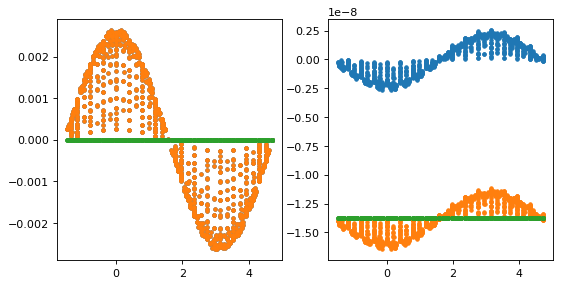

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

def test(K_in,b_in,sol_in):
    K=copy.deepcopy(K_in)
    b=copy.deepcopy(b_in)
    sol=copy.deepcopy(sol_in)
    
    nnode=len(nodes)
    nind=np.arange(0,nnode*3,3)+nnode*3+2
    print('K66 nind:',nind)
    print('K65 nind:',nind-1)
    print('K64 nind:',nind-2)
    print('K63 nind:',nind-nnode*3)
    print('K62 nind:',nind-nnode*3-1)
    print('K61 nind:',nind-nnode*3-2)
    print('')
    K66=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind).tocsr()
    K65=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-1).tocsr()
    K64=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-2).tocsr()
    K63=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-nnode*3).tocsr()
    K62=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-nnode*3-1).tocsr()
    K61=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-nnode*3-2).tocsr()
    
    b6=np.zeros(nnode,dtype=complex)
    #b6[:]=b[nind]-K63*sol[nind-nnode*3]
    b6[:]=(b6[:]-K65*sol[nind-1]-K64*sol[nind-2]-K63*sol[nind-nnode*3]-
           K62*sol[nind-nnode*3-1]-K61*sol[nind-nnode*3-2])
    print('K65 max(real) max(imag):',np.max(np.abs(np.real(K65))),np.max(np.abs(np.imag(K65))))
    print('K64 max(real) max(imag):',np.max(np.abs(np.real(K64))),np.max(np.abs(np.imag(K64))))
    print('K62 max(real) max(imag):',np.max(np.abs(np.real(K62))),np.max(np.abs(np.imag(K62))))
    print('K61 max(real) max(imag):',np.max(np.abs(np.real(K61))),np.max(np.abs(np.imag(K61))))
    print('')
    
    unod6=call_solver(K66,b6)
    rho,theta,phi=cartesian2spherical(nodes[nind_stern,0],nodes[nind_stern,1],nodes[nind_stern,2])
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    axs[0].plot(phi,np.real(unod6[nind_stern]),'.')
    axs[0].plot(phi,np.real(sol[nind][nind_stern]),'.')
    axs[0].plot(phi,np.real(sol[nind][nind_stern]-unod6[nind_stern]),'.')
    
    axs[1].plot(phi,np.imag(unod6[nind_stern]),'.')
    axs[1].plot(phi,np.imag(sol[nind][nind_stern]),'.')
    axs[1].plot(phi,np.imag(sol[nind][nind_stern]-unod6[nind_stern]),'.')
    plt.show()
    return

test(K1,b1,solution1)

# Test 6 (Check Test 5 results)

In [26]:
def set_materials2d(mesh,physics,u2d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    c=np.zeros((nface,3,3),dtype=complex)
    alpha_x=np.zeros((nface,3,3),dtype=complex)
    alpha_y=np.zeros((nface,3,3),dtype=complex)
    alpha_z=np.zeros((nface,3,3),dtype=complex)

    beta_x=np.zeros((nface,3,3),dtype=complex)
    beta_y=np.zeros((nface,3,3),dtype=complex)
    beta_z=np.zeros((nface,3,3),dtype=complex)

    gamma_x=np.zeros((nface,3),dtype=complex)
    gamma_y=np.zeros((nface,3),dtype=complex)
    gamma_z=np.zeros((nface,3),dtype=complex)

    a=np.zeros((nface,3,3),dtype=complex)
    f=np.zeros((nface,3),dtype=complex)
    gs=0j #placeholder; not implemented yet
    qs=0j #placeholder; not implemented yet
    snod=0j #placeholder; not implemented yet

    c[in_stern,2,2]=physics['diffusion_stern']
    gamma_x[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']*u2d[in_stern,1]
    gamma_y[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']*u2d[in_stern,2]
    gamma_z[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']*u2d[in_stern,3]
    a[in_stern,0,0]=1j*freq
    a[in_stern,1,1]=1j*freq
    a[in_stern,2,2]=1j*freq

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    return materials

def set_materials3d(mesh,physics,u3d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']

    c=np.zeros((nelem,3,3),dtype=complex)
    alpha_x=np.zeros((nelem,3,3),dtype=complex)
    alpha_y=np.zeros((nelem,3,3),dtype=complex)
    alpha_z=np.zeros((nelem,3,3),dtype=complex)

    beta_x=np.zeros((nelem,3,3),dtype=complex)
    beta_y=np.zeros((nelem,3,3),dtype=complex)
    beta_z=np.zeros((nelem,3,3),dtype=complex)

    gamma_x=np.zeros((nelem,3),dtype=complex)
    gamma_y=np.zeros((nelem,3),dtype=complex)
    gamma_z=np.zeros((nelem,3),dtype=complex)

    a=np.zeros((nelem,3,3),dtype=complex)
    f=np.zeros((nelem,3),dtype=complex)
    gs=np.zeros((nface,3),dtype=complex)
    qs=np.zeros((nface,3,3),dtype=complex)
    snod=np.zeros((nnode,3),dtype=complex)

    c[in_electrolyte,2,2]=perm0*physics['rel_perm_electrolyte']
    c[in_solid,2,2]=perm0*physics['rel_perm_solid']
    a[:,0,0]=1j*freq
    a[:,1,1]=1j*freq
    gs[in_stern,0]=0
    gs[in_stern,1]=0
    gs[in_stern,2]=u3d[2][in_stern,0]
    f[in_electrolyte,2]=kA*echarge*(u3d[1][in_electrolyte,0]-u3d[0][in_electrolyte,0])

    nodes=mesh['nodes']
    with_first_kind_bc=mesh['with_first_kind_bc']
    snod[with_first_kind_bc,2]=nodes[with_first_kind_bc,0]*1e6 #need to be updated

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    return materials

def build_system(mesh,materials2d,materials3d,case=1):
    nnode=len(mesh['nodes'])
    K=csr_matrix((nnode*6,nnode*6))
    b=np.zeros(nnode*6,dtype=complex)
    K,b=assemble_Ke3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=assemble_Ks3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=assemble_Ke2d(mesh,materials2d,K,b,offset=(nnode*3,nnode*3),nrep=3)
    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*3,nnode*3),nrep=3)
    
    return K,b

if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    #dist_factor=1e9
    dist_factor=1
    case=6
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    unod=np.load('sphere_s61_test5_1MV_new.npy')
    unod_list=reshape_solution(unod,nrep=3)
    u2d=grad2d(mesh['nodes'],mesh['faces'],unod_list[2])
    u3d=[grad3d(mesh['nodes'],mesh['elements'],unod_list[0]),
         grad3d(mesh['nodes'],mesh['elements'],unod_list[1]),
         grad2d(mesh['nodes'],mesh['faces'],unod_list[-1])]
    materials2d=set_materials2d(mesh,physics,u2d=u2d,freq=10,case=case)
    materials3d=set_materials3d(mesh,physics,u3d=u3d,freq=10,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #solution=call_solver(K/perm0,b/perm0)
    solution=call_solver(K,b)
    unod_list=reshape_solution(solution,nrep=3)
    output=output_unod(nodes,unod_list[0],srvfile)
    
    np.save('sphere_s61',solution)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS: 0.02
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -0.01
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: -0.01

Computing fields and field gradients on faces
Time elapsed  2.6111745834350586 sec

Computing fields and field gradients in elements
Time elapsed  4.302602529525757 sec

Computing fields and field gradients in elements
Time elapsed  4

In [50]:
K2=copy.deepcopy(K)
b2=copy.deepcopy(b)
solution2=copy.deepcopy(solution)

Calling sparse linear system solver
Time elapsed  0.014032363891601562 sec



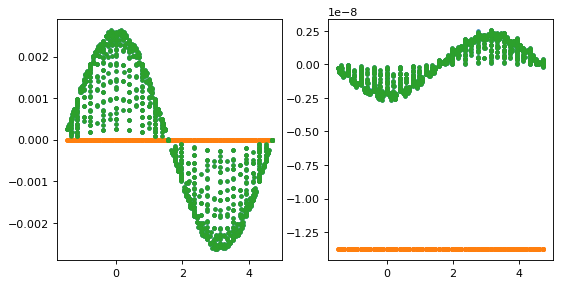

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

def test(K_in,b_in,sol_in):
    K=copy.deepcopy(K_in)
    b=copy.deepcopy(b_in)
    sol=copy.deepcopy(sol_in)
    
    nnode=len(nodes)
    nind=np.arange(0,nnode*3,3)+nnode*3+2
    K66=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind).tocsr()
    K63=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-nnode*3).tocsr()
    
    b6=np.zeros(nnode,dtype=complex)
    b6[:]=b[nind]-K63*sol[nind-nnode*3]
    
    unod6=call_solver(K66,b6)
    rho,theta,phi=cartesian2spherical(nodes[nind_stern,0],nodes[nind_stern,1],nodes[nind_stern,2])
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    axs[0].plot(phi,np.real(unod6[nind_stern]),'.')
    #axs[0].plot(phi,np.real(sol[nind][nind_stern]),'.')
    axs[0].plot(phi,np.real(sol[nind][nind_stern]-unod6[nind_stern]),'.')
    axs[0].plot(phi,np.real(solution2[nind][nind_stern]),'.')
    
    axs[1].plot(phi,np.imag(unod6[nind_stern]),'.')
    #axs[1].plot(phi,np.imag(sol[nind][nind_stern]),'.')
    axs[1].plot(phi,np.imag(sol[nind][nind_stern]-unod6[nind_stern]),'.')
    axs[1].plot(phi,np.imag(solution2[nind][nind_stern]),'.')
    plt.show()
    return

test(K1,b1,solution1)

In [ ]:
# def assemble_Ke2d3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
#     print('Implementing coupled terms of the system of equations (2/2)')
#     start=time.time()
#     in_stern=mesh['in_stern']
    
#     nodes=mesh['nodes']
#     faces_stern=mesh['faces'][in_stern]
#     nnode=len(mesh['nodes'])
#     nface_stern=len(faces_stern)
    
#     gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
#     gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))
    
#     cnt=len(K_in.data)
#     I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
#     J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
#     V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
#     I[:cnt]=K_in.tocoo().row
#     J[:cnt]=K_in.tocoo().col
#     V[:cnt]=K_in.data
#     b=np.array(b_in)
#     ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
#     COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
#     REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    
#     for i in range(nface_stern):
#         nind=faces_stern[i,:]
#         R=rotate_triangle(nodes[nind,:])
#         nodes_new=R.dot(nodes[nind,:].T).T
#         xnod=nodes_new[:,0]
#         ynod=nodes_new[:,1]
#         Ke,be=build_Ke2d3d(xnod,ynod,gamma_x=gamma_x[i],
#                            gamma_y=gamma_y[i],nrep=nrep)
#         nind_rep=REP[nind,:].flatten(order='C')
#         I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
#         J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
#         V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
#         b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
#         cnt=cnt+9*nrep**2
    
#     K=csr_matrix((V,(I,J)),shape=K_in.shape)
#     elapsed=time.time()-start
#     print('Time elapsed ',elapsed,'sec')
#     print('')
#     return K,b

def rearrange_system(K_in,b_in):
    nnode=len(nodes)
    K=copy.deepcopy(K_in)
    b=copy.deepcopy(b_in)
    nind=np.arange(0,nnode*3,3)+nnode*3+2
    K22=coo_submatrix_pull(K1.tocoo(),rows=nind,cols=nind).tocsr()
    K21=coo_submatrix_pull(K1.tocoo(),rows=nind,cols=nind-nnode*3).tocsr()
    b[nind]=b[nind]-K21.dot(unod_list_1MV[2])
    u=call_solver(K22,b[nind])
    
    K=zero_rows(K,nind)
    K=zero_cols(K,nind-nnode*3)
#     M=csr_matrix(K.shape).tolil()
#     M[nind,nind-nnode*3]=1
    solution2=call_solver(K,b)
    unod_list2=reshape_solution(solution2,nrep=3)
    
    fig,ax=plt.subplots()
    ax.plot(np.real(u-unod_list[-1]),'.')
    
    return

rearrange_system(K1,b1)
# M=sparse.eye(10, dtype=float).tolil()
# nind=np.arange(10)
# M[nind,nind]=2
# print(M)
# print(M[nind,nind])

Calling sparse linear system solver
Time elapsed  0.01054239273071289 sec

Calling sparse linear system solver
Time elapsed  0.008884668350219727 sec



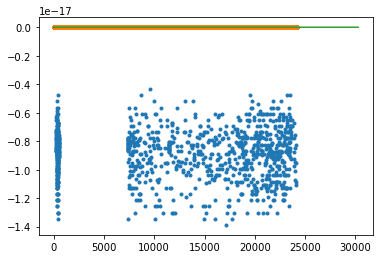

In [208]:
def test(K1_in,K2_in,b1_in,b2_in):
    K1=copy.deepcopy(K1_in)
    K2=copy.deepcopy(K2_in)
    b1=copy.deepcopy(b1_in)
    b2=copy.deepcopy(b2_in)
    nnode=len(nodes)
    
    nind=np.arange(0,nnode*3,3)+nnode*3+2
    K22_1=coo_submatrix_pull(K1.tocoo(), rows=nind, cols=nind).tocsr()
    K22_2=coo_submatrix_pull(K2.tocoo(), rows=nind, cols=nind).tocsr()
    K21_1=coo_submatrix_pull(K1.tocoo(), rows=nind, cols=nind-nnode*3).tocsr()
    u2_1=call_solver(K22_1,b1[nind]-K21_1.dot(unod_list_1MV[2]))
    u2_2=call_solver(K22_2,b2[nind])

    fig,ax=plt.subplots()
    ax.plot(np.real(u2_1-unod_list[-1]),'.')
    ax.plot(np.real(u2_2-unod_list[-1]),'.')
    ax.plot(np.imag(K22_1.data-K22_2.data))
    plt.show()

test(K1,K2,b1,b2)

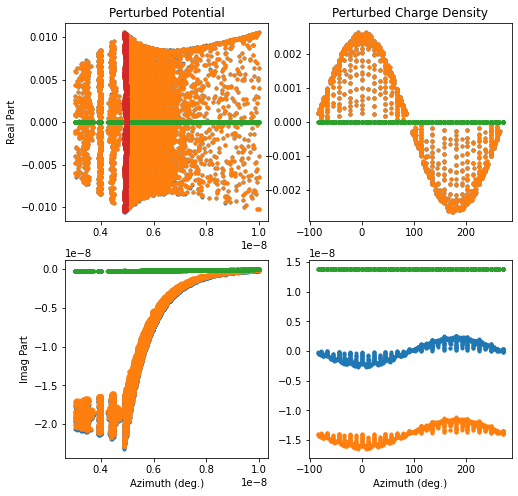

In [207]:
%matplotlib inline
import matplotlib.pyplot as plt

# solution2=call_solver(K/1e-9,b/1e-9)
# unod_list2=reshape_solution(solution2,nrep=3)

fig,ax=plt.subplots(2,2,figsize=(8,8))
axs=ax.flatten()

midpoints2d=compute_midpoints2d(mesh['nodes'],mesh['faces'])
rho2d,theta2d,phi2d=cartesian2spherical(midpoints2d[in_stern,0],midpoints2d[in_stern,1],midpoints2d[in_stern,2])
rho,theta,phi=cartesian2spherical(nodes[nind_stern,0],nodes[nind_stern,1],nodes[nind_stern,2])
dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
dist2d=np.sqrt(midpoints2d[:,0]**2+midpoints2d[:,1]**2+midpoints2d[:,2]**2)
mask=(dist>3e-9)&(dist<1e-8)

unod_list_1MV=reshape_solution(np.load('sphere_s61_test5_1MV.npy'),nrep=3)
# axs[0].plot(phi*180/np.pi,np.real(unod_list2[2][nind_stern]),'.')
# axs[0].plot(phi*180/np.pi,np.real(unod_list_1MV[2][nind_stern]),'.')
# axs[0].plot(phi*180/np.pi,np.real(unod_list2[2][nind_stern]-unod_list_1MV[2][nind_stern]),'.')
axs[0].plot(dist[mask],np.real(unod_list[2][mask]),'.')
axs[0].plot(dist[mask],np.real(unod_list_1MV[2][mask]),'.')
axs[0].plot(dist[mask],np.real(unod_list[2][mask]-unod_list_1MV[2][mask]),'.')
axs[0].plot(dist2d[in_stern],np.real(u2d[in_stern,0]),'.')

axs[1].plot(phi*180/np.pi,np.real(unod_list[-1][nind_stern]),'.')
axs[1].plot(phi*180/np.pi,np.real(unod_list_1MV[-1][nind_stern]),'.')
axs[1].plot(phi*180/np.pi,np.real(unod_list[-1][nind_stern]-unod_list_1MV[-1][nind_stern]),'.')

# axs[2].plot(phi*180/np.pi,np.imag(unod_list2[2][nind_stern]),'.')
# axs[2].plot(phi*180/np.pi,np.imag(unod_list_1MV[2][nind_stern]),'.')
# axs[2].plot(phi*180/np.pi,np.imag(unod_list2[2][nind_stern]-unod_list_1MV[2][nind_stern]),'.')
axs[2].plot(dist[mask],np.imag(unod_list[2][mask]),'.')
axs[2].plot(dist[mask],np.imag(unod_list_1MV[2][mask]),'.')
axs[2].plot(dist[mask],np.imag(unod_list[2][mask]-unod_list_1MV[2][mask]),'.')

axs[3].plot(phi*180/np.pi,np.imag(unod_list[-1][nind_stern]),'.')
axs[3].plot(phi*180/np.pi,np.imag(unod_list_1MV[-1][nind_stern]),'.')
axs[3].plot(phi*180/np.pi,np.imag(unod_list[-1][nind_stern]-unod_list_1MV[-1][nind_stern]),'.')

axs[0].set_title('Perturbed Potential')
axs[1].set_title('Perturbed Charge Density')
axs[0].set_ylabel('Real Part')
axs[2].set_ylabel('Imag Part')
axs[2].set_xlabel('Azimuth (deg.)')
axs[3].set_xlabel('Azimuth (deg.)')
plt.show()


In [82]:
print(perm0)
print(physics['mobility_stern'])
print(u2d[in_stern,1])

8.85e-12
5e-09
[2101171.10577344+1.08755824j 1812500.84898047-2.20133371j
 2068841.11470069-1.78101139j ... 1763945.21300662-1.14710652j
 1796752.82736862-0.70686032j 1799305.41998572-0.694712j  ]


# Test Case 2 (Nrep/K11/K22)

In [59]:
if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    case=2
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    ansol=ansol_sphere(mesh['midpoints'],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)

    materials2d=set_materials2d(mesh,physics,u=0,freq=0.1,case=case)
    materials3d=set_materials3d(mesh,physics,u=0,freq=0.1,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    #mesh_scale,materials3d_scale=scale_distance(mesh,materials3d,dist_factor)
    #mesh_subset,materials3d_subset=set_subdomains(mesh_scale,materials3d_scale)
    #K,b=build_system(mesh_subset,materials3d_subset,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #unod=call_solver(K/perm0,b/perm0)
    nnode=len(nodes)
    nrep=int(len(b)/len(nodes)/2)
    unod=call_solver(K,b)
    unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
    unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))
    
    output=output_unod(nodes,unod1[:,0],srvfile)
    u2d=grad2d(nodes,faces,unod1[:,0])
    u3d=grad3d(nodes,elements,unod1[:,0])
    np.save('sphere_s61',unod)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR STEADY STATE IS: -0.01

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Setting materials in stern layer using pre

# Test Case 3 (K12 was tested)

In [65]:
if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    case=3
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    ansol=ansol_sphere(mesh['midpoints'],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)

    materials2d=set_materials2d(mesh,physics,u=0,freq=0.1,case=case)
    materials3d=set_materials3d(mesh,physics,u=0,freq=0.1,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    #mesh_scale,materials3d_scale=scale_distance(mesh,materials3d,dist_factor)
    #mesh_subset,materials3d_subset=set_subdomains(mesh_scale,materials3d_scale)
    #K,b=build_system(mesh_subset,materials3d_subset,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #unod=call_solver(K/perm0,b/perm0)
    nnode=len(nodes)
    nrep=int(len(b)/len(nodes)/2)
    unod=call_solver(K,b)
    unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
    unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))
    
    output=output_unod(nodes,unod1[:,0],srvfile)
    u2d=grad2d(nodes,faces,unod1[:,0])
    u3d=grad3d(nodes,elements,unod1[:,0])
    np.save('sphere_s61',unod)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR STEADY STATE IS: -0.01

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Setting materials in stern layer using pre

# Test Case 4 (K21 was tested)

In [72]:
if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    case=4
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    ansol=ansol_sphere(mesh['midpoints'],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)

    materials2d=set_materials2d(mesh,physics,u=0,freq=0.1,case=case)
    materials3d=set_materials3d(mesh,physics,u=0,freq=0.1,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    #mesh_scale,materials3d_scale=scale_distance(mesh,materials3d,dist_factor)
    #mesh_subset,materials3d_subset=set_subdomains(mesh_scale,materials3d_scale)
    #K,b=build_system(mesh_subset,materials3d_subset,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #unod=call_solver(K/perm0,b/perm0)
    nnode=len(nodes)
    nrep=int(len(b)/len(nodes)/2)
    unod=call_solver(K,b)
    unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
    unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))
    
    output=output_unod(nodes,unod1[:,0],srvfile)
    u2d=grad2d(nodes,faces,unod1[:,0])
    u3d=grad3d(nodes,elements,unod1[:,0])
    np.save('sphere_s61',unod)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR STEADY STATE IS: -0.01

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: -0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Setting materials in stern layer using pr

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# meshfile='sphere_s61.hdf5'
# physfile='sphere_s61.hdf5'
# srvfile='sphere_complex.srv'
# dist_factor=1e9
# case=5

# #setup mesh and material properties
# mesh=import_mesh(meshfile)
# physics=import_physics(physfile)

# #initialize unknows
# nodes=mesh['nodes']
# elements=mesh['elements']
# faces=mesh['faces']

# in_active_zones=mesh['in_active_zones']
# in_stern=mesh['in_stern']
# nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
# nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))

# #unod=call_solver(K/perm0,b/perm0)
# nnode=len(nodes)
# nrep=3
# unod=np.load('sphere_s61.npy')
# unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
# unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))

output=output_unod(nodes,unod1[:,-1],srvfile)
# in_electrolyte=mesh['in_electrolyte']
# in_solid=mesh['in_solid']
# print(materials3d['cx'][in_electrolyte,0,0])
# print(materials3d['cx'][in_electrolyte,0,2])
# print(materials3d['cx'][in_electrolyte,2,2])

# print(materials3d['alpha_x'][in_electrolyte,0,0])
# print(materials3d['alpha_y'][in_electrolyte,0,0])
# print(materials3d['alpha_z'][in_electrolyte,0,0])

# print(np.sum(materials3d['alpha_z'][in_solid,:2,:2]))
# print(materials3d['a'][in_solid,2,2])

# print(physics['mobility_electrolyte'])
# print(echarge*kA)

def cartesian2spherical(x,y,z):
    rho=np.sqrt(x**2+y**2+z**2)
    theta=np.arccos(z/rho)
    #phi=np.arctan2(y/x)
    phi=np.zeros_like(rho)+np.pi/2
    mask=x>0
    phi[mask]=np.arctan(y[mask]/x[mask])
    mask=x<0
    phi[mask]=np.arctan(y[mask]/x[mask])+np.pi
    
    return rho,theta,phi

fig,ax=plt.subplots(2,2,figsize=(8,8))
axs=ax.flatten()

rho,theta,phi=cartesian2spherical(nodes[nind_stern,0],nodes[nind_stern,1],nodes[nind_stern,2])
# print(min(phi*180/np.pi))
# print(max(phi*180/np.pi))
axs[0].plot(phi*180/np.pi,np.real(unod2[nind_stern,-1]),'.')
axs[1].plot(phi*180/np.pi,np.real(unod1[nind_stern,-1]),'.')

axs[2].plot(phi*180/np.pi,np.imag(unod2[nind_stern,-1]),'.')
axs[3].plot(phi*180/np.pi,np.imag(unod1[nind_stern,-1]),'.')

axs[0].set_title('Perturbed Charge Density')
axs[1].set_title('Perturbed Potential')

axs[0].set_ylabel('Real Part')
axs[2].set_ylabel('Imag Part')

axs[2].set_xlabel('Azimuth (deg.)')
axs[3].set_xlabel('Azimuth (deg.)')
plt.show()

# fig,ax=plt.subplots()
# # ax.plot(nodes[nind_stern,0],nodes[nind_stern,1],'.')
# # ax.axis('equal')
# mask=(nodes[nind_stern,0]>0)&(nodes[nind_stern])

# Display Results

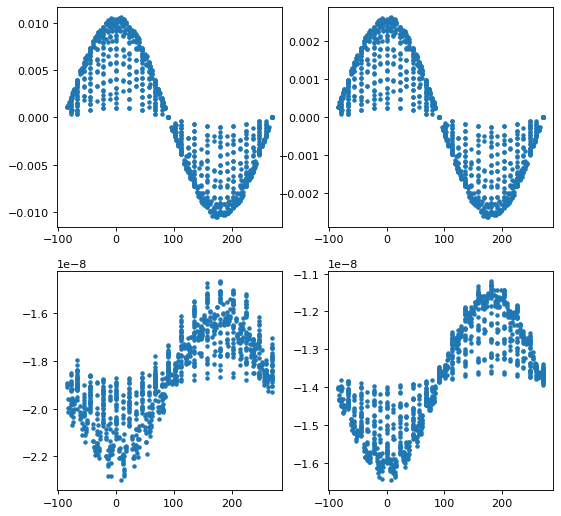

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

rho,theta,phi=cartesian2spherical(nodes[nind_stern,0],nodes[nind_stern,1],nodes[nind_stern,2])

fig,ax=plt.subplots(2,2,sharey=False,figsize=(8,8),dpi=80)
axs=ax.flatten()
axs[0].plot(phi*180/np.pi,np.real(unod_list[2][nind_stern]),'.')
axs[1].plot(phi*180/np.pi,np.real(unod_list[5][nind_stern]),'.')

axs[2].plot(phi*180/np.pi,np.imag(unod_list[2][nind_stern]),'.')
axs[3].plot(phi*180/np.pi,np.imag(unod_list[5][nind_stern]),'.')

plt.show()

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out



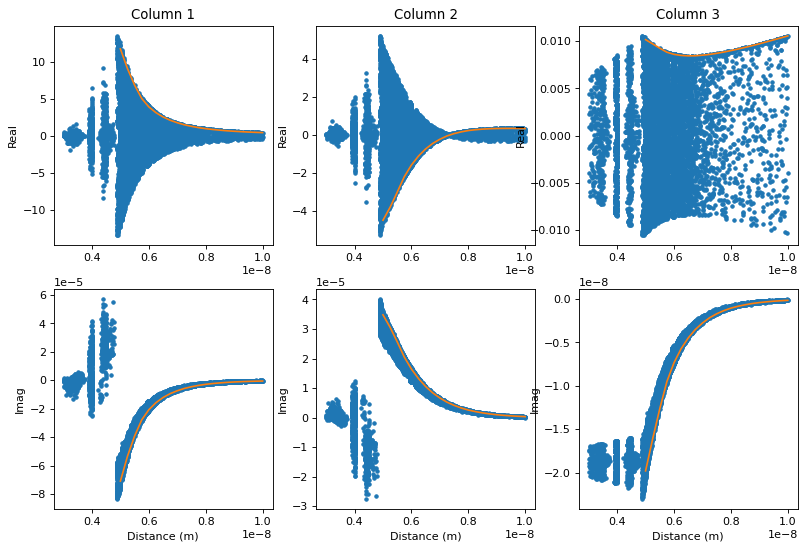

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

ansol=ansol_sphere(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
                   cinf=100,zval=1,zeta=0.01,gradflag=1)

fig,ax=plt.subplots(2,3,sharey=False,figsize=(12,8),dpi=80)
axs=ax.flatten()

dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
mask=(dist>3e-9)&(dist<1e-8)
# mask=(dist>.1e-9)&(dist<5e-9)
for i in range(len(unod_list[:3])):
    output=output_unod(nodes,unod_list[i],srvfile)
    
    axs[i].plot(dist[mask],np.real(unod_list[i][mask]),'.')
    #axs[i].plot(output[:,1],ansol[:,0],'*')
    axs[i].plot(output[:,1],output[:,6])
    axs[i].set_title('Column %d'%(i+1))
    axs[i].set_ylabel('Real')
    
    axs[i+3].plot(dist[mask],np.imag(unod_list[i][mask]),'.')
    axs[i+3].plot(output[:,1],output[:,7])
    axs[i+3].set_xlabel('Distance (m)')
    axs[i+3].set_ylabel('Imag')

plt.show()

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out



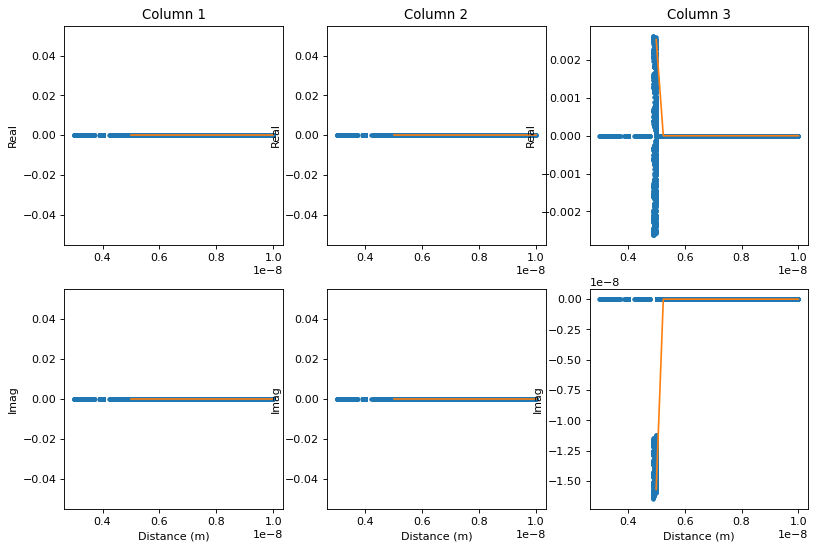

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

ansol=ansol_sphere(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
                   cinf=100,zval=1,zeta=0.01,gradflag=1)

fig,ax=plt.subplots(2,3,sharey=False,figsize=(12,8),dpi=80)
axs=ax.flatten()

dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
mask=(dist>3e-9)&(dist<1e-8)
# mask=(dist>.1e-9)&(dist<5e-9)
for i in range(len(unod_list[:3])):
    output=output_unod(nodes,unod_list[i+3],srvfile)
    
    axs[i].plot(dist[mask],np.real(unod_list[i+3][mask]),'.')
    #axs[i].plot(output[:,1],ansol[:,0],'*')
    axs[i].plot(output[:,1],output[:,6])
    axs[i].set_title('Column %d'%(i+1))
    axs[i].set_ylabel('Real')
    
    axs[i+3].plot(dist[mask],np.imag(unod_list[i+3][mask]),'.')
    axs[i+3].plot(output[:,1],output[:,7])
    axs[i+3].set_xlabel('Distance (m)')
    axs[i+3].set_ylabel('Imag')

plt.show()

Computing fields and field gradients in elements
Time elapsed  4.446779012680054 sec

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm



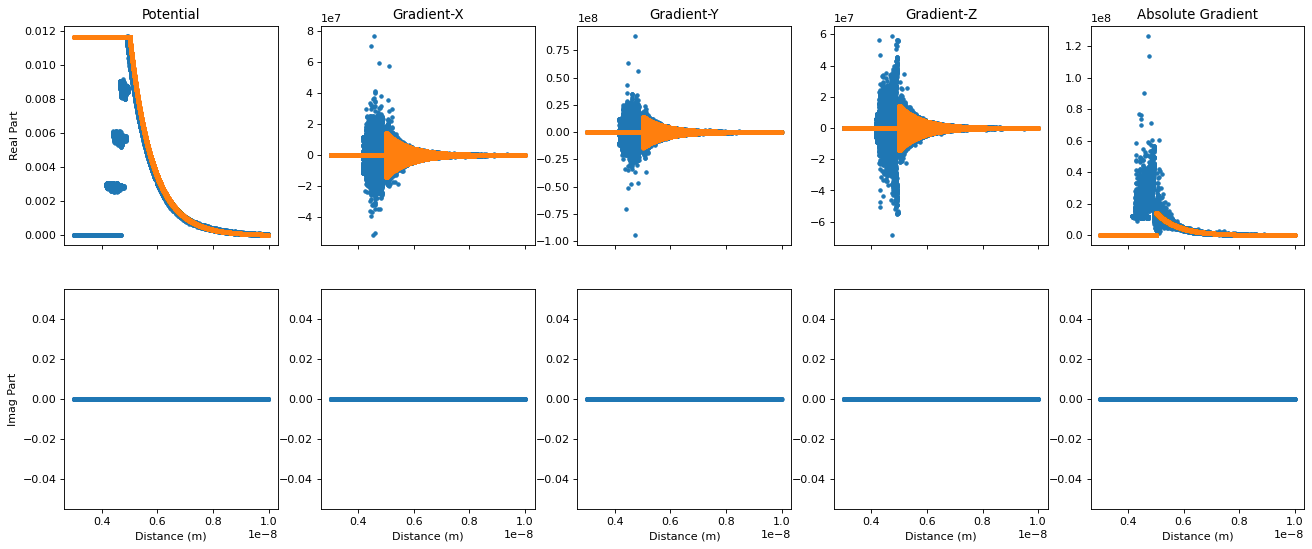

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

midpoints=compute_midpoints3d(nodes,elements)
dist=np.sqrt(midpoints[:,0]**2+midpoints[:,1]**2+midpoints[:,2]**2)
u3d=grad3d(nodes,elements,unod_list[0])
ansol=ansol_sphere(midpoints,a=5e-9,rel_perm=78.5,temp_K=298,
                   cinf=100,zval=1,zeta=0.01,gradflag=1)
u3d=np.append(u3d,np.asmatrix(np.sqrt(u3d[:,1]**2+u3d[:,2]**2+u3d[:,3]**2)).T,axis=1)
ansol=np.append(ansol,np.asmatrix(np.sqrt(ansol[:,1]**2+ansol[:,2]**2+ansol[:,3]**2)).T,axis=1)

fig,ax=plt.subplots(2,5,sharex=True,figsize=(20,8),dpi=80)
axs=ax.flatten()
titles=['Potential','Gradient-X','Gradient-Y','Gradient-Z','Absolute Gradient']

mask=(dist>3e-9)&(dist<1e-8)
# mask=(dist>5e-9)&(dist<1e-8)
for i in range(u3d.shape[1]):
    axs[i].plot(dist[mask],np.real(u3d[mask,i]),'.')
    axs[i].plot(dist[mask],ansol[mask,i],'.')
    axs[i].set_title(titles[i])
    
    axs[i+5].plot(dist[mask],np.imag(u3d[mask,i]),'.')
    axs[i+5].set_xlabel('Distance (m)')
    
axs[0].set_ylabel('Real Part')
axs[5].set_ylabel('Imag Part')
plt.show()